In [469]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import dateutil as du
import math
import json
import numpy as np
import re
%matplotlib inline

pd.set_option('display.max_columns', None)

**1. How has the popularity of different genres changed over the last ~8 years?**

Note tmdb popularity is a measurement very specific to the day the data was copied, so I'll be using vote_average

In [713]:
tmdb = pd.read_csv('clean_data/clean_tmdb.csv')

In [714]:
tmdb.head(2)

,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788,False,True,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False
1,10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,False,True,True,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False


In [715]:
tmdb = tmdb.drop(tmdb[tmdb.vote_average == 0].index)

In [716]:
tmdb.describe()
tmdb[tmdb.vote_count >= 5].describe()

,id,popularity,vote_average,vote_count
count,13037.000000,13037.000000,13037.000000,13037.000000
mean,254790.557950,5.125075,5.922919,347.926287
std,151470.691405,5.129856,1.220891,1255.339302
min,27.000000,0.600000,1.000000,5.000000
25%,102899.000000,1.716000,5.200000,9.000000
50%,260313.000000,3.264000,6.000000,24.000000
75%,381649.000000,7.118000,6.800000,108.000000
max,589023.000000,80.773000,10.000000,22186.000000


Looking at films with 5 or more votes to lessen the effect of any rogue voters: the vote_average median hasn't changed and the quartiles are both moved in by 0.2, showing the movies with few votes were distributed towards the extremes (though fairly balanced), reinforcing my decision.

In [717]:
tmdb = tmdb[tmdb.vote_count >= 5]

In [ ]:
#Next: 

In [896]:
genres = tmdb.iloc[:,8:].columns

In [ ]:
#Rolling average period: half year. Firstly  for all films

In [721]:
tmdb.release_date = tmdb.release_date.\
                    apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d').date())

In [722]:
tmdb = tmdb.sort_values(by = ['release_date'])

In [723]:
#test: set up 12-month window 
centre = dt.date(2008, 1, 1)
start = centre - du.relativedelta.relativedelta(months = 6)
end = centre + du.relativedelta.relativedelta(months = 6)

In [725]:
tmdb = tmdb[tmdb.release_date > start]

In [921]:
begin = dt.date(2008, 1, 1)
data = []
genres = tmdb.iloc[:,8:].columns
for m in range(0, 141, 3):
    #select films within date window and declare that as tmdb_win
    centre = begin + du.relativedelta.relativedelta(months = m)
    start = centre - du.relativedelta.relativedelta(months = 3)
    end = centre + du.relativedelta.relativedelta(months = 3)
    tmdb_win = tmdb[(tmdb.release_date > start) & (tmdb.release_date <= end)]
    gdata = {}
    for g in genres:
        #for each genre get aggregate data (of films within window)
        num_films = tmdb_win[tmdb_win[g]].vote_average.count()
#         #If there are no films, keep previous results
#         if num_films == 0 & m == 0:
#             gdata[g] = {'median_vote':0, 
#                     'median_vote_count':0,
#                     'num_films':0,
#                     'weighted_mean':0,
#                     'weighted_sum':0,
#                     'weighted_log_sum':0,
#                     'weighted_log_mean':0
#                     }
#             break
#         elif num_films == 0:
#             gdata[g] = data[m-1][g]
#             break
        
        median_vote = tmdb_win[tmdb_win[g]].vote_average.median()
        mean_vote = tmdb_win[tmdb_win[g]].vote_average.median()
        median_vote_count = tmdb_win[tmdb_win[g]].vote_count.mean()
        mean_vote_count = tmdb_win[tmdb_win[g]].vote_count.mean()
        
        #find vote_average weighted by vote_count, and log(vote_count)
        weighted_sum = 0
        weighted_log_sum = 0
        for h, d in tmdb_win[tmdb_win[g]].iterrows():
            weighted_sum += d.vote_average * d.vote_count
            weighted_log_sum = d.vote_average * math.log(d.vote_count, 100)
        
        weighted_mean = round(weighted_sum / num_films, 2)
        weighted_log_mean = round(weighted_log_sum / num_films, 2)
        
        #create dict of genre data, add it to dict of genre data for the month
        gdata[g] = {'median_vote':median_vote, 
#                     'mean_vote':mean_vote,
#                     'median_vote_count':median_vote_count,
#                     'mean_vote_count':mean_vote_count,
                    'num_films':num_films,
                    'weighted_sum':weighted_sum,
                    'weighted_mean':weighted_mean,
#                     'weighted_log_sum':weighted_log_sum,
#                     'weighted_log_mean':weighted_log_mean,
#                     'meanv_x_meanvc':mean_vote*mean_vote_count,
                    'meanv_x_logmeanvc':mean_vote*math.log(mean_vote_count, 10),
                    'date': begin +du.relativedelta.relativedelta(months = m)
                    }
            
    #add month's genre data to data list
    data.append(gdata)

C:\Users\Maltanno\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\Maltanno\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


In [922]:
df = pd.DataFrame(data)
df.transpose();

In [923]:
df.Animation.apply(pd.Series).columns

Index(['median_vote', 'num_films', 'weighted_sum', 'weighted_mean',
       'weighted_log_sum', 'weighted_log_mean', 'meanv_x_logmeanvc', 'date'],
      dtype='object')

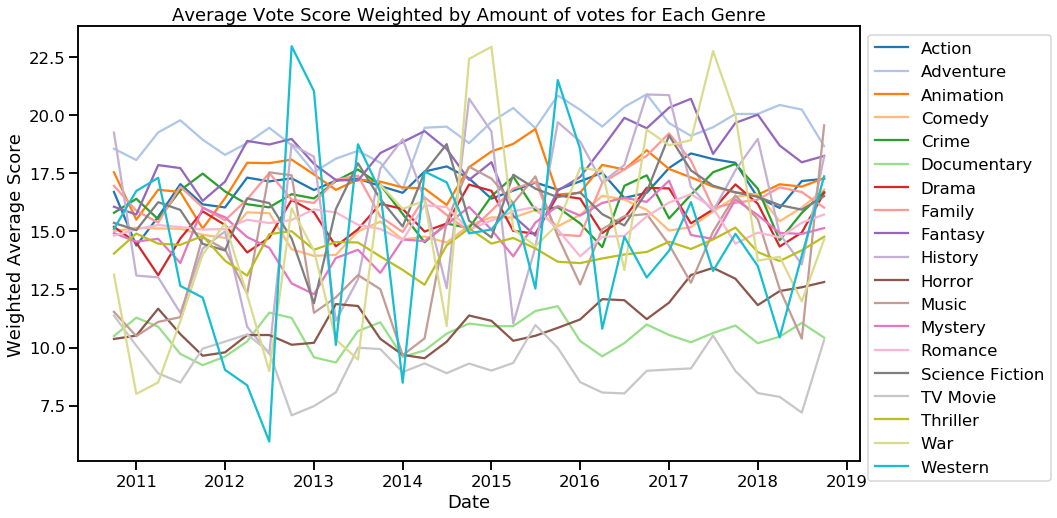

In [940]:
genres_small = ['Action', 'Comedy', 'Documentary', 'Drama',
                'Horror', 'Romance', 'Thriller']
genres_all = list(tmdb.iloc[:,8:].columns)
genres = genres_all

fig, ax = plt.subplots(figsize=(14,8))
cm=plt.get_cmap('tab20')
ax.set_prop_cycle(color=[cm(i/len(genres)) for i in range(len(genres))])

for g in genres:
    sns.lineplot(x='date', y='meanv_x_logmeanvc', 
                 data = df[g].apply(pd.Series)[11:-3], label=g)
ax.legend(loc='upper left', bbox_to_anchor=(1,1))
ax.set(xlabel='Date', ylabel='Weighted Average Score', 
       title = 'Average Vote Score Weighted by Amount of votes for Each Genre');
plt.savefig('Western2_fig.png')

In [863]:
genres_small

['Action',
 'Comedy',
 'Documentary',
 'Drama',
 'Horror',
 'Romance',
 'Thriller',
 'Adventure',
 'Animation',
 'Crime',
 'Family',
 'Fantasy',
 'History',
 'Music',
 'Mystery',
 'Science Fiction',
 'TV Movie',
 'War',
 'Western']

In [858]:
tmdb.iloc[:,8:].columns

Index(['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Mystery',
       'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western'],
      dtype='object')

**2. Which two people make the most gross when working together?**

In [530]:
prin = pd.read_csv('clean_data/clean_principles.csv')
bas = pd.read_csv('clean_data/clean_basics.csv')
bud = pd.read_csv('clean_data/clean_movie_budgets.csv')
nam = pd.read_csv('clean_data/clean_names.csv')

In [158]:
prin.head()

,tconst,ordering,nconst,category,characters
0,tt0111414,1,nm0246005,actor,"[""The Man""]"
1,tt0111414,2,nm0398271,director,NaN
2,tt0111414,3,nm3739909,producer,NaN
3,tt0323808,10,nm0059247,editor,NaN
4,tt0323808,1,nm3579312,actress,"[""Beth Boothby""]"


In [161]:
len(prin.tconst.unique())

143454

In [194]:
films = prin.tconst.unique()

In [201]:
pairs = {}
for f in films:
    for i, nm in enumerate(prin[prin.tconst == f].nconst):
         for n in prin[prin.tconst == f].nconst[i+1:]:
            names = [n,nm]
            names.sort()
            pair = names[0]+'_'+names[1]
            if pairs.get(pair):
                pairs[pair] = pairs[pair] + [f]
            else:
                pairs[pair] = [f]
            

KeyboardInterrupt: 

In [215]:
bud.drop(columns = 'Unnamed: 0', inplace = True)

In [222]:
bud.set_index('movie', inplace = True)

In [226]:
basbud = bas.join(bud, on = 'primary_title', how = 'inner')

In [165]:
a ={'b':1}
if a.get('b'):
    print('yes')


yes


In [192]:
pairs[pair]
for i, nm in enumerate(prin[prin.tconst == 'tt0111414'].nconst):
     for n in prin[prin.tconst == 'tt0111414'].nconst[i+1:]:
        names = [n,nm]
        names.sort()
        pair = names[0]+'_'+names[1]
        
        if pairs.get(pair):
            pairs[pair] = pairs[pair] + 1
        else:
            pairs[pair] = 1
            
        print(i, pair, pairs[pair])

0 nm0246005_nm0398271 3
0 nm0246005_nm3739909 3
1 nm0398271_nm3739909 3


TypeError: can only concatenate list (not "str") to list

In [244]:
prinbasbud = prin.merge(basbud, left_on = 'tconst', right_on = 'tconst')

In [240]:
prin[prin.tconst == 'tt0475290']

,tconst,ordering,nconst,category,characters
36,tt0475290,10,nm0005683,cinematographer,NaN
37,tt0475290,1,nm0000982,actor,"[""Eddie Mannix""]"
38,tt0475290,2,nm0000123,actor,"[""Baird Whitlock""]"
39,tt0475290,3,nm2403277,actor,"[""Hobie Doyle""]"
40,tt0475290,4,nm0000146,actor,"[""Laurence Laurentz""]"
41,tt0475290,5,nm0001053,director,NaN
42,tt0475290,6,nm0001054,director,NaN
43,tt0475290,7,nm0079677,producer,NaN
44,tt0475290,8,nm0271479,producer,NaN
45,tt0475290,9,nm0001980,composer,NaN


In [223]:
bud

,id,release_date,production_budget,domestic_gross,worldwide_gross
movie,,,,,
Avatar,1,"Dec 18, 2009",425000000,760507625,2776345279
Pirates of the Caribbean: On Stranger Tides,2,"May 20, 2011",410600000,241063875,1045663875
Dark Phoenix,3,"Jun 7, 2019",350000000,42762350,149762350
Avengers: Age of Ultron,4,"May 1, 2015",330600000,459005868,1403013963
Star Wars Ep. VIII: The Last Jedi,5,"Dec 15, 2017",317000000,620181382,1316721747
...,...,...,...,...,...
Red 11,78,"Dec 31, 2018",7000,0,0
Following,79,"Apr 2, 1999",6000,48482,240495
Return to the Land of Wonders,80,"Jul 13, 2005",5000,1338,1338


In [245]:
len(prinbasbud.tconst.unique())

3525

,tconst,primary_title,original_title,start_year,runtime_minutes,genres,g,Action,Crime,Drama,...,News,Talk-Show,Reality-TV,Game-Show,Short,id,release_date,production_budget,domestic_gross,worldwide_gross
19,tt0249516,Foodfight!,Foodfight!,2012,91.0,"Action,Animation,Comedy",False,True,False,False,...,False,False,False,False,False,26,"Dec 31, 2012",45000000,0,73706
31,tt0293429,Mortal Kombat,Mortal Kombat,2021,87.0,"Action,Adventure,Fantasy",False,True,False,False,...,False,False,False,False,False,10,"Aug 18, 1995",20000000,70433227,122133227
42,tt0337692,On the Road,On the Road,2012,124.0,"Adventure,Drama,Romance",False,False,False,True,...,False,False,False,False,False,17,"Mar 22, 2013",25000000,720828,9313302
38356,tt2404548,On the Road,On the Road,2011,90.0,Drama,False,False,False,True,...,False,False,False,False,False,17,"Mar 22, 2013",25000000,720828,9313302
66405,tt3872966,On the Road,On the Road,2013,87.0,Documentary,False,False,False,False,...,False,False,False,False,False,17,"Mar 22, 2013",25000000,720828,9313302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139226,tt9678962,Fuel,Fuel,2018,87.0,"Documentary,Sport",False,False,False,False,...,False,False,False,False,False,35,"Nov 14, 2008",2500000,174255,174255
139516,tt9729206,Diner,Diner,2019,87.0,Crime,False,False,True,False,...,False,False,False,False,False,11,"Apr 2, 1982",5000000,12592907,12592907
139988,tt9805168,Traitor,Traitor,2015,110.0,"Action,Drama,Romance",False,True,False,True,...,False,False,False,False,False,25,"Aug 27, 2008",22000000,23530831,27882226
140228,tt9844102,Ray,Ray,2018,111.0,Crime,False,False,True,False,...,False,False,False,False,False,8,"Oct 29, 2004",40000000,75305995,124823094


In [228]:
basbud

,tconst,primary_title,original_title,start_year,runtime_minutes,genres,g,Action,Crime,Drama,...,News,Talk-Show,Reality-TV,Game-Show,Short,id,release_date,production_budget,domestic_gross,worldwide_gross
19,tt0249516,Foodfight!,Foodfight!,2012,91.0,"Action,Animation,Comedy",False,True,False,False,...,False,False,False,False,False,26,"Dec 31, 2012",45000000,0,73706
31,tt0293429,Mortal Kombat,Mortal Kombat,2021,87.0,"Action,Adventure,Fantasy",False,True,False,False,...,False,False,False,False,False,10,"Aug 18, 1995",20000000,70433227,122133227
42,tt0337692,On the Road,On the Road,2012,124.0,"Adventure,Drama,Romance",False,False,False,True,...,False,False,False,False,False,17,"Mar 22, 2013",25000000,720828,9313302
38356,tt2404548,On the Road,On the Road,2011,90.0,Drama,False,False,False,True,...,False,False,False,False,False,17,"Mar 22, 2013",25000000,720828,9313302
66405,tt3872966,On the Road,On the Road,2013,87.0,Documentary,False,False,False,False,...,False,False,False,False,False,17,"Mar 22, 2013",25000000,720828,9313302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139226,tt9678962,Fuel,Fuel,2018,87.0,"Documentary,Sport",False,False,False,False,...,False,False,False,False,False,35,"Nov 14, 2008",2500000,174255,174255
139516,tt9729206,Diner,Diner,2019,87.0,Crime,False,False,True,False,...,False,False,False,False,False,11,"Apr 2, 1982",5000000,12592907,12592907
139988,tt9805168,Traitor,Traitor,2015,110.0,"Action,Drama,Romance",False,True,False,True,...,False,False,False,False,False,25,"Aug 27, 2008",22000000,23530831,27882226
140228,tt9844102,Ray,Ray,2018,111.0,Crime,False,False,True,False,...,False,False,False,False,False,8,"Oct 29, 2004",40000000,75305995,124823094


In [253]:
films = prinbasbud.tconst.unique()

In [260]:
pairs = {}
for f in films:
    print(f)
    for i, n1 in enumerate(prinbasbud[prinbasbud.tconst == f].nconst):
         for n2 in prin[prin.tconst == f].nconst[i+1:]:
            
            names = [n2,n1]
            names.sort()
            pair = names[0]+'_'+names[1]
            if pairs.get(pair):
                pairs[pair] = pairs[pair] + [f]
            else:
                pairs[pair] = [f]
            

tt0475290
tt10300704
tt1083452
tt1124037
tt1216492
tt1226229
tt1226753
tt1251743
tt1254978
tt1389139
tt1403241
tt1470020
tt1478338
tt1560985
tt1605783
tt1666186
tt1667310
tt1706620
tt1712261
tt1726592
tt1822311
tt1914258
tt1922679
tt1951212
tt1959490
tt2083383
tt2090488
tt2097826
tt0480687
tt0959329
tt10073018
tt1015471
tt1228705
tt1230120
tt1489889
tt1566501
tt1601913
tt1611224
tt1646127
tt1648168
tt1693039
tt1787759
tt1831825
tt1865346
tt1872026
tt2015381
tt2023587
tt2083355
tt2089701
tt2096673
tt2103217
tt2112209
tt2167202
tt0947810
tt10155932
tt10388520
tt1053424
tt1255919
tt1314190
tt1320291
tt1321869
tt1391137
tt1418377
tt1453405
tt1488589
tt1541995
tt1599354
tt1610996
tt1675192
tt1714210
tt1764615
tt1807022
tt1810683
tt1844203
tt1884318
tt1980074
tt2077772
tt2083347
tt2140479
tt10013288
tt1001526
tt1082807
tt1205537
tt1355683
tt1418646
tt1554091
tt1599348
tt1615065
tt1620680
tt1656190
tt1709105
tt1719676
tt1748207
tt1753460
tt1758810
tt1764234
tt1772252
tt1772341
tt1772422
tt180

tt1411704
tt1502407
tt1512235
tt1562847
tt1564585
tt1655400
tt1682180
tt1684628
tt1726669
tt1727497
tt1727824
tt1737256
tt1739304
tt1740017
tt1800241
tt1817771
tt1855401
tt1865538
tt1911600
tt1956620
tt2170439
tt2187884
tt2304459
tt2304933
tt0770703
tt0810913
tt1007029
tt1041804
tt1216475
tt1247667
tt1291584
tt1656186
tt1727261
tt1922685
tt2024506
tt2091256
tt2109176
tt2159988
tt2176228
tt2316649
tt0472399
tt0840361
tt0993842
tt10265934
tt1093357
tt1147681
tt1226837
tt1284575
tt1430612
tt1457767
tt1483013
tt1587310
tt1623205
tt1625346
tt1629705
tt1657507
tt1664775
tt1727816
tt1790885
tt1796616
tt1853728
tt1858800
tt1870529
tt1872194
tt1877707
tt1989646
tt2015323
tt2061758
tt2246526
tt2317796
tt0787474
tt0864835
tt1024648
tt1106860
tt1228987
tt1245534
tt1285009
tt1302011
tt1411238
tt1411250
tt1431045
tt1431065
tt1433183
tt1554921
tt1596363
tt1612319
tt1655441
tt1699745
tt1702455
tt1716777
tt1837703
tt1859650
tt1981107
tt2094064
tt2103281
tt2292959
tt2294629
tt2328900
tt0490215
tt1137470

tt2322932
tt2388715
tt2402157
tt2409300
tt2704752
tt2952692
tt3089954
tt3151724
tt3182596
tt3289416
tt3312830
tt3322940
tt3421204
tt3611318
tt2334649
tt2387433
tt2388050
tt2402597
tt2403415
tt2404163
tt2446980
tt2561572
tt2948840
tt2949588
tt2980648
tt3216348
tt3341072
tt3397884
tt3530002
tt3722070
tt2205401
tt2288438
tt2317003
tt2361317
tt2814362
tt2955096
tt2963344
tt2967008
tt3099498
tt3108662
tt3480796
tt3659388
tt2345737
tt2392373
tt2395427
tt2458724
tt2690138
tt2937898
tt2938464
tt3210686
tt3311168
tt3319070
tt3439758
tt3599496
tt3605418
tt3843072
tt2389182
tt2486682
tt2739338
tt3076658
tt3282076
tt3283708
tt3523348
tt3786446
tt2286560
tt2335176
tt2408288
tt2473794
tt2492700
tt2607640
tt2879218
tt3045616
tt3096900
tt3215846
tt3261880
tt3277624
tt3963812
tt2353965
tt2358925
tt2366608
tt2402927
tt2404233
tt2404311
tt2668120
tt2693114
tt2762040
tt2928902
tt2963656
tt3106750
tt3110770
tt3152288
tt3289362
tt3453052
tt3596332
tt3612616
tt3631112
tt3961040
tt2448756
tt2466604
tt2513868


tt4995858
tt4034228
tt4123430
tt4278204
tt4309446
tt4555426
tt4569764
tt4590482
tt4975722
tt5212650
tt5368500
tt5678896
tt4117096
tt4278026
tt4501454
tt4765284
tt4972582
tt5437970
tt5537146
tt5684336
tt5688932
tt5805026
tt4136848
tt4170206
tt4439120
tt4467202
tt4669788
tt4670270
tt5083738
tt5112932
tt5263832
tt5354458
tt5662906
tt3882396
tt4094724
tt4519438
tt4549796
tt4650752
tt4665626
tt4778988
tt4782052
tt4786282
tt4862056
tt4881806
tt5300472
tt5439796
tt3868240
tt3882082
tt4074762
tt4080386
tt4330758
tt4361256
tt4476736
tt4667094
tt4828926
tt4877122
tt5270724
tt5271436
tt4139124
tt4158096
tt4219836
tt4238858
tt4282764
tt4412528
tt4431574
tt4897908
tt5815346
tt6107516
tt3837024
tt3864056
tt4064912
tt4073790
tt4113020
tt4287320
tt4340720
tt4630562
tt4697228
tt4700594
tt4701724
tt4741258
tt4828330
tt4925292
tt5169904
tt5270158
tt5274738
tt5357254
tt5690360
tt6000478
tt3890160
tt3892618
tt4121152
tt4145324
tt4560436
tt4586720
tt4991702
tt5094332
tt5113040
tt5118062
tt5203734
tt5457656


tt7555254
tt7785302
tt8404256
tt9248762
tt9252692
tt7526304
tt8197998
tt8399650
tt7255884
tt7319268
tt7909340
tt7935392
tt8439948
tt8653840
tt8681390
tt8802728
tt7967412
tt8421518
tt8692378
tt9149142
tt9893078
tt6985094
tt7121588
tt7143650
tt7855934
tt7865910
tt8107598
tt8558276
tt9054566
tt9664284
tt9703646
tt7379226
tt7394636
tt7720054
tt7906260
tt8027144
tt8332280
tt8352082
tt8788464
tt8835030
tt9048972
tt9430578
tt9701552
tt8680408
tt8816388
tt9125432
tt9827712
tt7388562
tt7480724
tt7611352
tt7620218
tt8063826
tt8180058
tt9001554
tt9313936
tt6498340
tt6501192
tt6924650
tt7002100
tt7137846
tt7456310
tt8045822
tt8633120
tt8655470
tt8666442
tt8844252
tt9607270
tt9618596
tt6684818
tt6845582
tt7263736
tt8941440
tt8976772
tt8980174
tt9053958
tt9064942
tt9111170
tt9134678
tt9379256
tt9691476
tt9698912
tt7325124
tt7598276
tt7722258
tt8152324
tt8155288
tt8526282
tt8601408
tt8632862
tt9024106
tt9087212
tt9125468
tt9861522
tt6450186
tt6473952
tt7476946
tt7981006
tt9574444
tt7721552
tt7738704


In [257]:
len(pairs)

899

Not reaching end, printing film to see if it gets stuck or just takes a long time

In [307]:
# Took a long time to get pairs, so saving it as a json file:
json = json.dumps(pairs)
f = open('name_pairs', 'w')
f.write(json)
f.close()

In [274]:
pairs_c = pairs.copy()

In [290]:
multi_pairs ={}
for k, v in pairs_c.items():
    if len(v) > 2:
        multi_pairs[k] = v
len(multi_pairs)

In [279]:
len(pairs)

121692

In [280]:
pairs_c['nm3868049_nm7786516']

['tt9678962']

In [291]:
len(multi_pairs)

724

In [306]:
mp_df = pd.DataFrame.from_dict(multi_pairs, orient = 'index')

In [337]:
prinbasbud['RoI'] = prinbasbud.apply(lambda x: (x.worldwide_gross-x.production_budget)/x.production_budget, axis=1)

In [296]:
pairs.to_csv('clean_data/name_pairs.csv', index = False)

AttributeError: 'dict' object has no attribute 'to_csv'

In [308]:
mp_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
nm0001053_nm0001054,tt0475290,tt1809398,tt2042568,tt1403865,tt3682448,None,None,None,None,None,None,None,None,None,None,None,None,None
nm0079677_nm0271479,tt0475290,tt0947810,tt1213663,tt1524137,tt1092026,tt2328900,tt2194499,tt1781769,tt1340800,tt3787590,tt2980516,tt2719848,tt4085696,tt3569230,tt3569230,tt4555426,tt3890160,tt6811018
nm0717230_nm5473782,tt1083452,tt2066051,tt2802144,tt4649466,None,None,None,None,None,None,None,None,None,None,None,None,None,None
nm0092061_nm0717230,tt1083452,tt2066051,tt2802144,tt4649466,None,None,None,None,None,None,None,None,None,None,None,None,None,None
nm0092061_nm5473782,tt1083452,tt2066051,tt2802144,tt4649466,None,None,None,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nm0236026_nm5203687,tt8601408,tt8601408,tt8601408,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
nm5203687_nm7252419,tt8601408,tt8601408,tt8601408,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
nm5203687_nm7242775,tt8601408,tt8601408,tt8601408,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
nm2812499_nm5203687,tt8601408,tt8601408,tt8601408,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [336]:
prinbasbud.drop(prinbasbud[prinbasbud.RoI==0].index, inplace = True)

In [453]:
prinbasbud.columns

Index(['tconst', 'ordering', 'nconst', 'category', 'characters',
       'primary_title', 'original_title', 'start_year', 'runtime_minutes',
       'genres', 'g', 'Action', 'Crime', 'Drama', 'Biography', 'Comedy',
       'Fantasy', 'Horror', 'Thriller', 'Adventure', 'Animation',
       'Documentary', 'History', 'Mystery', 'Sci-Fi', 'Romance', 'Family',
       'War', 'Music', 'Sport', 'Western', 'Musical', 'Adult', 'News',
       'Talk-Show', 'Reality-TV', 'Game-Show', 'Short', 'id', 'release_date',
       'production_budget', 'domestic_gross', 'worldwide_gross', 'RoI'],
      dtype='object')

In [354]:
def get_insert(col):

    insert = {}
    for f in prinbasbud.iterrows():
        insert[f[1].tconst] = f[1][col]
        
    return insert

In [358]:
RoI = get_insert('RoI')

In [420]:
mp_roi = mp_df.replace(RoI)

In [382]:
np.percentile(np.array(mp_roi.loc['nm0001053_nm0001054']
         [mp_roi.loc['nm0001053_nm0001054'].notnull()]), 30)

1.9320837636363637

In [378]:
np.array(mp_roi.loc['nm0001053_nm0001054']
         [mp_roi.loc['nm0001053_nm0001054'].notnull()])

array([1.9163945454545455, 1.5158126769230769, 1.9948406363636364,
       6.207912228571429, 3.06245845], dtype=object)

In [379]:
mp_roi.loc['nm0001053_nm0001054'][mp_roi.loc['nm0001053_nm0001054'].notnull()]

0    1.91639
1    1.51581
2    1.99484
3    6.20791
4    3.06246
Name: nm0001053_nm0001054, dtype: object

In [400]:
mp_roi.loc['nm0001053_nm0001054'][mp_roi.loc['nm0001053_nm0001054'].notnull()]

0    1.91639
1    1.51581
2    1.99484
3    6.20791
4    3.06246
Name: nm0001053_nm0001054, dtype: object

In [409]:
mp_roi.reset_index(inplace = True)

In [413]:
mp_roi.rename(columns = {'index': 'pair'}, inplace = True)

In [414]:
mp_roi.head()

,pair,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,nm0001053_nm0001054,1.91639,1.51581,1.99484,6.20791,3.06246,None,None,None,None,None,None,None,None,None,None,None,None,None
1,nm0079677_nm0271479,1.91639,-0.0247698,1.37543,2.93627,1.52905,0.869389,6.44243,0.449074,2.87871,4.07671,7.22185,2.40457,20.8507,0.697018,0.697018,4.02691,5.70895,-0.519518
2,nm0717230_nm5473782,0.959151,1.64982,3.30385,2.9308,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,nm0092061_nm0717230,0.959151,1.64982,3.30385,2.9308,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,nm0092061_nm5473782,0.959151,1.64982,3.30385,2.9308,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [417]:
def percentile(x, p):
    
    return np.percentile(np.array(mp_roi.loc[pair == x][mp_roi.loc[pair == x].notnull()]), p)
    
    

In [418]:
mp_roi['percentile_thirty'] = mp_roi.pair.apply(lambda x: percentile(x, 30))

KeyError: False

In [385]:
mp_roi

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
nm0001053_nm0001054,1.91639,1.51581,1.99484,6.20791,3.06246,None,None,None,None,None,None,None,None,None,None,None,None,None
nm0079677_nm0271479,1.91639,-0.0247698,1.37543,2.93627,1.52905,0.869389,6.44243,0.449074,2.87871,4.07671,7.22185,2.40457,20.8507,0.697018,0.697018,4.02691,5.70895,-0.519518
nm0717230_nm5473782,0.959151,1.64982,3.30385,2.9308,None,None,None,None,None,None,None,None,None,None,None,None,None,None
nm0092061_nm0717230,0.959151,1.64982,3.30385,2.9308,None,None,None,None,None,None,None,None,None,None,None,None,None,None
nm0092061_nm5473782,0.959151,1.64982,3.30385,2.9308,None,None,None,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nm0236026_nm5203687,88.5863,88.5863,88.5863,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
nm5203687_nm7252419,88.5863,88.5863,88.5863,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
nm5203687_nm7242775,88.5863,88.5863,88.5863,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
nm2812499_nm5203687,88.5863,88.5863,88.5863,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [ ]:
np.percentile(np.array(mp_roi.loc['nm0001053_nm0001054']
         [mp_roi.loc['nm0001053_nm0001054'].notnull()]), 30)

In [393]:
np.array(mp_roi.loc['nm0001053_nm0001054'])[np.isreal(np.array(mp_roi.loc['nm0001053_nm0001054'].notnull()))]

array([1.9163945454545455, 1.5158126769230769, 1.9948406363636364,
       6.207912228571429, 3.06245845, None, None, None, None, None, None,
       None, None, None, None, None, None, None], dtype=object)

In [395]:
np.percentile(np.array(mp_roi.loc['nm0001053_nm0001054'])[np.isreal(np.array(mp_roi.loc['nm0001053_nm0001054'].notnull()))], 50)

TypeError: '<' not supported between instances of 'NoneType' and 'float'

In [432]:
for col in range(724):
    print(col, mp_roi.transpose().iloc[:,col].median())

0 1.9948406363636364
1 2.1604823573426573
2 2.2903136651031897
3 2.2903136651031897
4 2.2903136651031897
5 2.1073606
6 1.286396875
7 1.0541273
8 2.611284330357143
9 2.2298029062499998
10 5.009557576923077
11 7.911754553846154
12 7.911754553846154
13 3.436891543410853
14 3.436891543410853
15 3.436891543410853
16 3.436891543410853
17 3.436891543410853
18 3.436891543410853
19 -0.11074640909090909
20 2.8787052857142856
21 2.3897376688034186
22 1.1732054
23 1.1732054
24 1.1732054
25 0.90263685
26 1.1732054
27 1.1732054
28 0.8017416333333334
29 3.560277652
30 2.9915776316923774
31 4.160401374192378
32 3.348331708119658
33 3.99034635
34 -0.1439652424242424
35 1.16643272
36 0.697018
37 1.1860755125
38 1.17862715
39 18.19469638383686
40 0.04674021052631579
41 0.04674021052631579
42 0.04674021052631579
43 -0.8827620333333334
44 1.6158962


TypeError: could not convert string to float: 'tt2935510'

In [436]:
mp_roi = mp_roi.transpose()

In [439]:
mp_roi.nm0001053_nm0001054

0     1.91639
1     1.51581
2     1.99484
3     6.20791
4     3.06246
5        None
6        None
7        None
8        None
9        None
10       None
11       None
12       None
13       None
14       None
15       None
16       None
17       None
Name: nm0001053_nm0001054, dtype: object

In [443]:
#Remove films without an entry in prinbasbud
mp_roi.replace(to_replace = 'tt*', value = np.nan, regex = True, inplace = True)

In [445]:
mp_roi = mp_roi.transpose()

In [456]:
mp_roi.quantile(q = 0.3, numeric_only = True, axis = 1)

nm0001053_nm0001054     1.932084
nm0079677_nm0271479     0.919993
nm0717230_nm5473782     1.580755
nm0092061_nm0717230     1.580755
nm0092061_nm5473782     1.580755
                         ...    
nm0236026_nm5203687    88.586336
nm5203687_nm7252419    88.586336
nm5203687_nm7242775    88.586336
nm2812499_nm5203687    88.586336
nm2418386_nm2812499    88.586336
Name: 0.3, Length: 724, dtype: float64

In [459]:
mp_roi = mp_roi.join(mp_roi.quantile(q = 0.3, numeric_only = True, axis = 1))

In [462]:
mp_roi.rename(columns = {0.3:'percentile_thirty'}, inplace=True)

In [450]:
title = get_insert('primary_title')

In [451]:
mp_title = mp_df.replace(title)

In [537]:
mp_rt = mp_roi.join(mp_title, rsuffix = '_title')

In [ ]:
#Some films are entered more than once

In [544]:
mp_rt = mp_rt[mp_rt.apply(lambda x: x.nunique() > 7, axis = 1)]
# -8 is 3 RoIs, 1 percentile_thirty, 3 titles

In [547]:
mp_rt.sort_values(by = 'percentile_thirty', ascending = False, inplace = True)

In [581]:
mp_rt.head(40)

,pair,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,percentile_thirty,0_title,1_title,2_title,3_title,4_title,5_title,6_title,7_title,8_title,9_title,10_title,11_title,12_title,13_title,14_title,15_title,16_title,17_title,name_one,name_two,profession_one,profession_two
0,nm1177766_nm1490123,65.580591,38.517372,15.788559,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.425847,Insidious,Annabelle,Insidious: The Last Key,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Joseph Bishara,James Wan,"composer,music_department,actor","producer,writer,director"
1,nm0484907_nm2305431,27.563598,40.407969,58.170677,17.180971,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.525336,Paranormal Activity 4,Paranormal Activity 3,Paranormal Activity 2,Paranormal Activity: The Marked Ones,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Christopher Landon,Oren Peli,"writer,producer,director","producer,writer,director"
2,nm0089658_nm2124081,40.407969,-0.998489,65.580591,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.845386,Paranormal Activity 3,Area 51,Insidious,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Jason Blum,Steven Schneider,"producer,executive,actor","producer,writer"
3,nm2124081_nm2305431,40.407969,-0.998489,65.580591,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.845386,Paranormal Activity 3,Area 51,Insidious,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Steven Schneider,Oren Peli,"producer,writer","producer,writer,director"
4,nm0089658_nm0484907,27.563598,40.407969,58.170677,17.180971,24.002052,6.131055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.591511,Paranormal Activity 4,Paranormal Activity 3,Paranormal Activity 2,Paranormal Activity: The Marked Ones,Happy Death Day,Happy Death Day 2U,None,None,None,None,None,None,None,None,None,None,None,None,Jason Blum,Christopher Landon,"producer,executive,actor","writer,producer,director"
5,nm0755911_nm1490123,14.900007,38.517372,19.358991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.575397,The Conjuring,Annabelle,Annabelle: Creation,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Peter Safran,James Wan,"producer,manager","producer,writer,director"
6,nm1160962_nm1413364,27.563598,40.407969,2.532614,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.551205,Paranormal Activity 4,Paranormal Activity 3,Nerve,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Henry Joost,Ariel Schulman,"writer,producer,director","writer,producer,director"
7,nm0089658_nm2305431,27.563598,40.407969,-0.998489,58.170677,65.580591,0.027421,17.180971,15.788559,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.927800,Paranormal Activity 4,Paranormal Activity 3,Area 51,Paranormal Activity 2,Insidious,The Lords of Salem,Paranormal Activity: The Marked Ones,Insidious: The Last Key,None,None,None,None,None,None,None,None,None,None,Jason Blum,Oren Peli,"producer,executive,actor","producer,writer,director"
8,nm0081514_nm0089658,18.735563,54.792961,11.265175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.747408,The Visit,Split,Glass,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Marc Bienstock,Jason Blum,"producer,production_manager,director","producer,executive,actor"
9,nm0089658_nm0796117,18.735563,54.792961,11.265175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.747408,The Visit,Split,Glass,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Jason Blum,M. Night Shyamalan,"producer,executive,actor","producer,writer,director"


In [545]:
len(mp_rt)

524

In [575]:
def find_name(ncode):
    return nam[nam.nconst == ncode].primary_name.item()
def find_profession(ncode):
    return nam[nam.nconst == ncode].primary_profession.item()

In [566]:
ncode = 'nm0062070'
nam[nam.nconst == ncode].primary_name.item()

C:\Users\Maltanno\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: `item` has been deprecated and will be removed in a future version
  


'Bruce Baum'

In [551]:
mp_rt = mp_rt.reset_index().rename(columns = {'index': 'pair'})

In [578]:
mp_rt['name_one'] = mp_rt.pair.apply(lambda x: find_name(x.split('_')[0]))
mp_rt['name_two'] = mp_rt.pair.apply(lambda x: find_name(x.split('_')[1]))

C:\Users\Maltanno\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: `item` has been deprecated and will be removed in a future version
  


In [579]:
mp_rt['profession_one'] = mp_rt.pair.apply(lambda x: find_profession(x.split('_')[0]))
mp_rt['profession_two'] = mp_rt.pair.apply(lambda x: find_profession(x.split('_')[1]))

C:\Users\Maltanno\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: `item` has been deprecated and will be removed in a future version
  after removing the cwd from sys.path.


In [592]:
mp_rt_results = mp_rt.iloc[:,19:].head(100)

In [602]:
#drop rows where there are no more than 2 films from different franchises as 
#...this doesn't show that it's the people working together, just that the 
#...franchises made money, looking though, picked by hand
mp_rt_results = mp_rt_results.drop([0,1,4,5,6,8,9,10,12,13,14,15,16,17,18,19,20,21,22,23,25,26,
                    27,28,29,30,34,35,36,37,38,39,40,43,45,46,47,48,49,50,51,52,
                    53,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,71,72,73,74,
                    75,76,78,79,80,81,82,83,84,85,86,88,89,90,91,92,93,94,95,96,
                    97,98,99])

In [622]:
mp_rt_results = mp_rt_results.reset_index().drop(columns = 'index')
mp_rt_results = mp_rt_results.drop(12).reset_index().drop(columns = 'index')

In [649]:
#No. of films (or franchises) they were in together
mp_rt_results['num'] = [3, 3, 4, 3, 5, 4, 4, 3, 3, 4, 3, 3, 3]

In [618]:
mp_rt_results_f = mp_rt.iloc[:,19:].head(100)
mp_rt_results_f.head(50)

,percentile_thirty,0_title,1_title,2_title,3_title,4_title,5_title,6_title,7_title,8_title,9_title,10_title,11_title,12_title,13_title,14_title,15_title,16_title,17_title,name_one,name_two,profession_one,profession_two
0,29.425847,Insidious,Annabelle,Insidious: The Last Key,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Joseph Bishara,James Wan,"composer,music_department,actor","producer,writer,director"
1,26.525336,Paranormal Activity 4,Paranormal Activity 3,Paranormal Activity 2,Paranormal Activity: The Marked Ones,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Christopher Landon,Oren Peli,"writer,producer,director","producer,writer,director"
2,23.845386,Paranormal Activity 3,Area 51,Insidious,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Jason Blum,Steven Schneider,"producer,executive,actor","producer,writer"
3,23.845386,Paranormal Activity 3,Area 51,Insidious,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Steven Schneider,Oren Peli,"producer,writer","producer,writer,director"
4,20.591511,Paranormal Activity 4,Paranormal Activity 3,Paranormal Activity 2,Paranormal Activity: The Marked Ones,Happy Death Day,Happy Death Day 2U,None,None,None,None,None,None,None,None,None,None,None,None,Jason Blum,Christopher Landon,"producer,executive,actor","writer,producer,director"
5,17.575397,The Conjuring,Annabelle,Annabelle: Creation,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Peter Safran,James Wan,"producer,manager","producer,writer,director"
6,17.551205,Paranormal Activity 4,Paranormal Activity 3,Nerve,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Henry Joost,Ariel Schulman,"writer,producer,director","writer,producer,director"
7,15.927800,Paranormal Activity 4,Paranormal Activity 3,Area 51,Paranormal Activity 2,Insidious,The Lords of Salem,Paranormal Activity: The Marked Ones,Insidious: The Last Key,None,None,None,None,None,None,None,None,None,None,Jason Blum,Oren Peli,"producer,executive,actor","producer,writer,director"
8,15.747408,The Visit,Split,Glass,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Marc Bienstock,Jason Blum,"producer,production_manager,director","producer,executive,actor"
9,15.747408,The Visit,Split,Glass,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Jason Blum,M. Night Shyamalan,"producer,executive,actor","producer,writer,director"


Looking for the pairs: if they are only in one or two films, or franchises, together then it could be the films carrying them. So I dropped those pairs from the results that only happened to be in the same franchise together. However, though I may not have the statistics each full franchise, I feel I must mention them. Towards the top end are Horror franchises: Insidious, Paranormal Activity, Annabelle. Then there's M. Night Shyamalan's Unbreakable/Split/Glass series, before the more family friendly Despicable Me. We then leave family friendly far behind again with The Purge and Fifty Shades

In [643]:
mp_rt_results['pair'] = mp_rt_results.apply(lambda x: x.name_one+'_'+x.name_two, axis = 1)

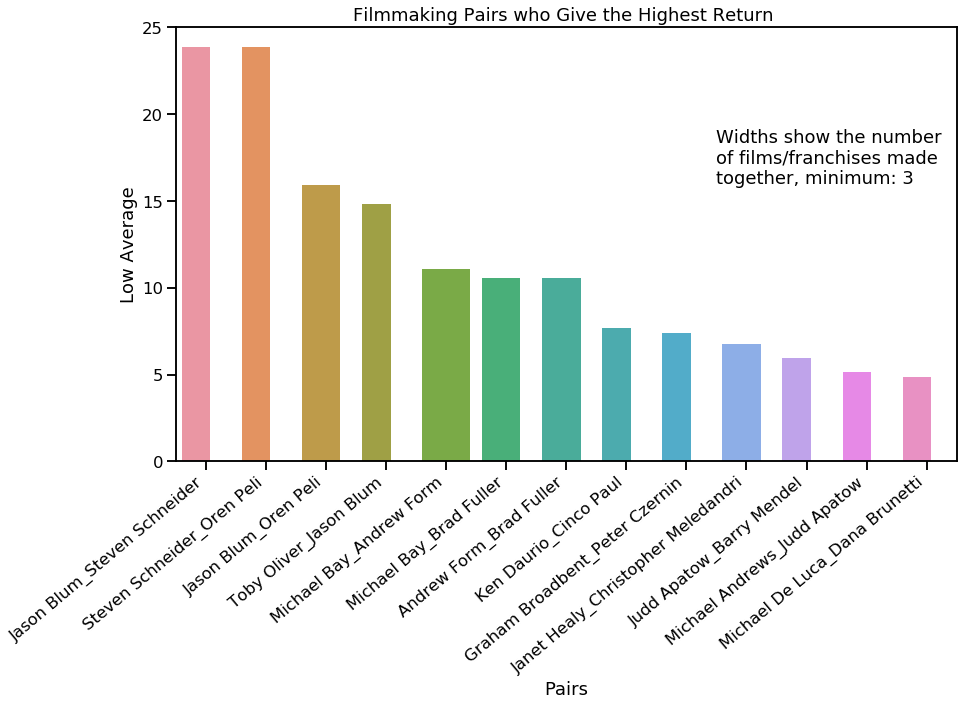

In [773]:
fig, ax = plt.subplots(figsize=(14,8))
sns.barplot(ax=ax, x='pair', y='percentile_thirty', data=mp_rt_results)
sns.set_context(context='talk')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha='right')
widths = mp_rt_results.num.tolist()
ax.set(xlabel='Pairs', ylabel='Low Average',
       title='Filmmaking Pairs who Give the Highest Return ')
for i, patch in enumerate(ax.patches):
    current_width = patch.get_width()
    patch.set_width(current_width*widths[i]/5)
    
ax.text(8.5, 16, 'Widths show the number \nof films/franchises made \ntogether, minimum: 3')
plt.show;
plt.savefig('pairs_fig.png')

[3, 3, 4, 3, 5, 4, 4, 3, 3, 4, 3, 3, 3]

In [811]:
math.log(10,100)

0.5